In [1]:
## Import
import os
from fetalxbrainxmultiomics.deepNeuron.model import ConvolutionalClassificationModel
from fetalxbrainxmultiomics.deepNeuron.utils import *
import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt

/home/camiel/anaconda3/envs/fetal_brain_multiomics/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/camiel/anaconda3/envs/fetal_brain_multiomics/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


## 1a. How to load the trained model

In [2]:
model = ConvolutionalClassificationModel(n_celltypes=5, length=401)
model.load_state_dict(torch.load('../fetalxbrainxmultiomics/deepNeuron/DeepNeuron.pth'))
model.eval()

# model(pred_sequences).detach().numpy() ## Your pred_sequences have to be in a torch tensor size [N sequences,4, length sequence] (one-hot encoded ACGT)

ConvolutionalClassificationModel(
  (cnn): Sequential(
    (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(256, 60, kernel_size=(3,), stride=(1,), padding=same)
    (5): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(60, 60, kernel_size=(5,), stride=(1,), padding=same)
    (9): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=same)
    (13): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

## 1b. How to train a new  model

If you want to apply the model to a different organism/cell types you will need to retrain it, but you can of course use the architecture as we have it outlined here. 

Below is the python script we use for training. 

Your traning/validation data should be a list of enhancers in the form below where every entry is a tuple of an enhancer + label:

```
(torch.tensor(enhancer.astype(‘float32’), torch.tensor(label.astype(‘float32’))) ## enhancer shape [4,length]
```

While you can train the model from this  notebook, I recommend running this as a seperate script as it can sometimes take some time to finish training.

In [ ]:
# Model based on convolutional layers
import sys
from typing import Tuple, Any, Optional
from fetalxbrainxmultiomics.deepNeuron.model import ConvolutionalClassificationModel
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from Bio import motifs
import numpy as np
import logging
 
smooth = .1
dropout = .4
 
# Loading saved data
train_data = torch.load(f'torch_data/training_set.pt')
test_data = torch.load(f'torch_data/test_set.pt')
out_file = 'model.pth'
 
# Using dataloader for easy imput of data into the Deep Learning network
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)
 
logging.info(f"Label smoothing: {smooth}")
# Asigning model parameters, logger(using tensorboard on server to assess running metrics)
model = ConvolutionalClassificationModel(n_celltypes=5, length=train_data[0][0].shape[1], dense=256, dropout=dropout, label_smoothing= smooth)
logger = TensorBoardLogger(save_dir='lightning_logs', name=f'DeepNeuron', default_hp_metric=False)
 
# Specifying training run
trainer = Trainer(accelerator = "gpu", devices = 1, max_epochs = 400, logger=logger, callbacks=[EarlyStopping(monitor="validation_loss", mode="min", patience=10)])
 
# Actual code that will start the training of the model
trainer.fit(model, train_loader, test_loader)

## Save final model
torch.save(model.state_dict(), out_file)

## 2. Test model accuracy on prediction sequences

(508,) (1991,)
ROC AUC: 0.92
CB_Exc  0.92
HB_Exc  0.91
Tel_Exc  0.88
MB_Inh  0.95
Purkinje  0.96


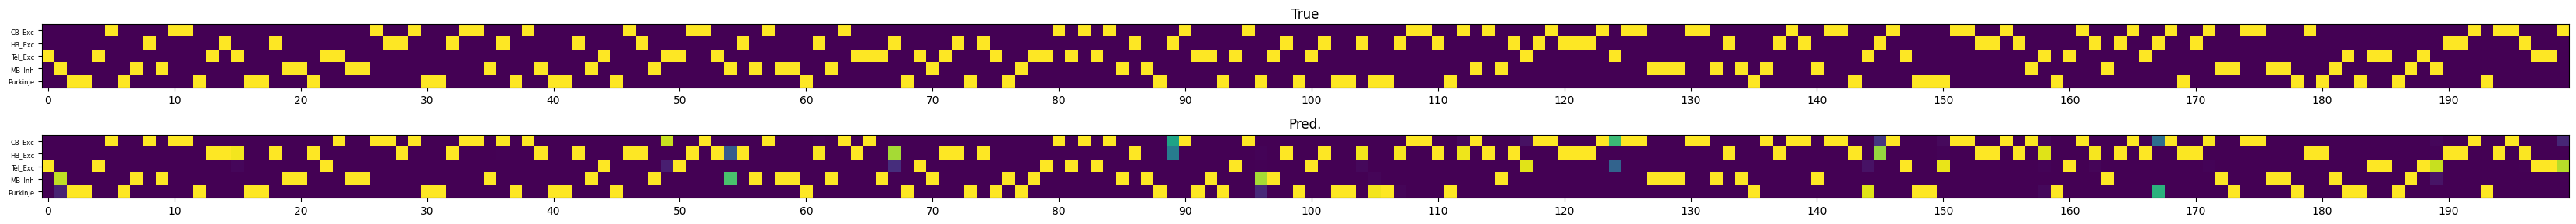

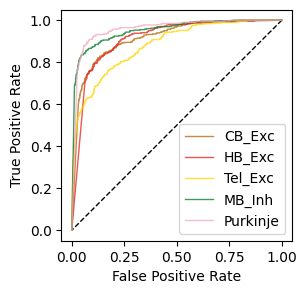

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
import glob    

## Cluster names and corresponding colors
colors = ["#B36305", "#E32017", "#FFD300", "#00782A",
          "#F3A9BB"]
ClusterNames = ['CB_Exc', 'HB_Exc', 'Tel_Exc', 'MB_Inh', 'Purkinje'] ## Corresponding to the labels
data_dir = '../files/torch_data/'
    
pred_set = torch.load(os.path.join(data_dir, 'pred_set.pt'))
pred_sequences = torch.tensor(np.array([x[0].numpy() for x in pred_set]))
true_labels = np.array([x[1] for x in pred_set]).astype(int)
names = np.load(os.path.join(data_dir, 'pred_names.npy'))
    
## CNN
N = 200
n_class = len(np.unique(true_labels))

model = ConvolutionalClassificationModel(n_celltypes=5, length=401)
model.load_state_dict(torch.load('../fetalxbrainxmultiomics/deepNeuron/DeepNeuron.pth'))
model.eval()

CNN_pred = model(pred_sequences).detach().numpy()

fig, ax = plt.subplots(2,1, figsize=(N,3))
im1 = np.zeros((CNN_pred.shape[1],N))
for i in range(N):
    im1[true_labels[i],i]=1
ax[0].imshow(im1)
ax[0].set_title('True')
ax[0].set_yticks(np.arange(CNN_pred.shape[1]), labels = ClusterNames, fontsize=6)
ax[0].set_xticks(np.arange(0,N,10))
ax[1].imshow(CNN_pred[:N,:].T)
ax[1].set_title('Pred.')
ax[1].set_yticks(np.arange(CNN_pred.shape[1]), labels = ClusterNames, fontsize=6)
ax[1].set_xticks(np.arange(0,N,10))
plt.tight_layout()

preds = np.argmax(CNN_pred,axis=1)
x = np.where(true_labels != preds)[0]
incorrect = names[x]

print(incorrect.shape, preds.shape)

onehot_label = np.eye(n_class)[true_labels].astype(int)
print(f'ROC AUC: {roc_auc_score(np.eye(n_class)[true_labels].astype(int), CNN_pred):.2f}')
for i in range(n_class):
    x = true_labels == i
    print(f'{ClusterNames[i]}  {roc_auc_score(x, CNN_pred[:,i].flatten()):.2f}')
    
plt.figure(figsize=(3,3))
plt.plot([1,0],[1,0], linestyle='--', c='black', lw=1)
plt.gca().set_aspect('equal')
for i in range(5):
    fpr, tpr, thresholds = roc_curve(true_labels==i, CNN_pred[:,i])
    plt.plot(fpr, tpr, label = ClusterNames[i], color=colors[i], lw=1, alpha=.75)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

## 3. Calculate contribution scores

For more information on contribution scores check out [deeplift](https://github.com/kundajelab/deeplift).


In [6]:
## For this example we only calculate the contribution scores for the first 100 prediction sequences. 
## For the best motif discovery results you should calculate the contributio score for as many of your sequences as you can (prediction, training, validation)

N = 100

contrib_scores, norm_scores = compute_contrib(model, pred_sequences[:N,:,:], true_labels[:N])

## np.save(outdir + )

  0%|          | 0/100 [00:00<?, ?it/s]/home/camiel/anaconda3/envs/fetal_brain_multiomics/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:307: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
100%|██████████| 100/100 [07:21<00:00,  4.41s/it]


In [ ]:
## Hypothetical contribution scores can be calculated as follows

hypo_contrib = compute_hypo_contrib(model, pred_sequences[:N,:,:], true_labels[:N])

 85%|████████▌ | 85/100 [06:20<01:06,  4.46s/it]

In [ ]:
## Below we plot the contribution score, normalized contribution and hypothetical contribution for the first sequence

from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(contrib_scores[0], subticks_frequency=20)
viz_sequence.plot_weights(norm_scores[0], subticks_frequency=20)
viz_sequence.plot_weights(hypo_contrib[0], subticks_frequency=20)

## TF-MoDisco

We have used the original TF-MoDisco implementation for the work in the paper, however we recommend using the updated ['lite' version](https://github.com/jmschrei/tfmodisco-lite) as it is more user friendly (with pattern matching!) and contains some useful bugfixes. To use the version we applied go to the [original repository](https://github.com/kundajelab/tfmodisco). I also recommend the notebooks in this repository for more details on hit scoring etc.

For completion's sake I added the script we used to run modisco below (run as 'python modisco.py {cluster_id}').

Before running the script make sure you have all the contribution and hypothetical scores in a folder. This will likely take a long time. 
Due to the file size restrictions of github the training files in torch data had to be compressed. Please use gunzip before continueing. 

In [ ]:
data_dir = '../files/torch_data/'

files = [os.path.join(data_dir, f'{x}_set.pt') for x in ['pred', 'test', 'training']] ## ['pred', 'test', 'training']
sequences, true_labels = [], []
for f in files:
    data = torch.load(f)
    sequences.append(torch.tensor(np.array([x[0].numpy() for x in data])))
    true_labels.append(np.array([x[1] for x in data]).astype(int))
sequences = np.array([x for s in sequences for x in s])
true_labels = np.array([x for s in true_labels for x in s])

contrib_scores, norm_scores = compute_contrib(model, pred_sequences, true_labels)
np.save('all_contrib.npy',contrib_scores)
np.save('all_norm.npy',norm_scores)

hypo_contrib = compute_hypo_contrib(model, pred_sequences, true_labels)
np.save('all_hyp_contrib.npy',hypo_contrib)


In [ ]:
import matplotlib.pyplot as plt

from typing import List
import sys, os

import numpy as np
import multiprocessing as mp
import torch
import h5py

import modisco
import pickle as pkl
import logging

proj_dir = '' ## Fill in the location of your project folder
data_dir = os.path.join(proj_dir, 'torch_data/')
outdir = 'output'

selected = int(sys.argv[1]) ## Supply the script with the cluster ID to use

files = [os.path.join(data_dir, f'{x}_set.pt') for x in ['pred', 'test', 'training']] ## ['pred', 'test', 'training']
sequences, true_labels = [], []
for f in files:
    data = torch.load(f)
    sequences.append(torch.tensor(np.array([x[0].numpy() for x in data])))
    true_labels.append(np.array([x[1] for x in data]).astype(int))
sequences = np.array([x for s in sequences for x in s])
true_labels = np.array([x for s in true_labels for x in s])

## Load contributions and hypothetical contributions
contribs = np.load(os.path.join(proj_dir, 'all_contrib.npy')).transpose((0,2,1))
hypotheticals = np.load(os.path.join(proj_dir, 'all_hyp_contrib.npy')).transpose((0,2,1))

onehot_data = [x.numpy() for x in sequences]

task_to_scores = []
task_to_hyp_scores = []
onehot_data = []
    
sel = true_labels == selected
logging.info(np.sum(sel))
task_to_scores.append({'task0':np.array([x for x in contribs[sel]])})
task_to_hyp_scores.append({'task0':np.array([x for x in hypotheticals[sel]])})
onehot_data.append(np.array([x.numpy().T for x in sequences[sel]]))
    
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
# for i in range(0,len(np.unique(true_labels))):
hdf5_file = os.path.join(outdir, f"results_{selected}.hdf5")
if not os.path.isfile(hdf5_file):
    logging.info(f'### processing {selected} ###')
    tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
        #Slight modifications from the default settings
        sliding_window_size=15, ## 15, 21
        flank_size=5, ## 5, 10
        target_seqlet_fdr=0.15,
        seqlets_to_patterns_factory=
        modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
            #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
            # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
            # initialization, you would specify the initclusterer_factory as shown in the
            # commented-out code below:
            #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
            #    meme_command="meme", base_outdir="meme_out",            
            #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
            trim_to_window_size=15, ## 15, 30
            initial_flank_to_add=5, ## 5, 10
            final_flank_to_add=5, ## 5, 0
            final_min_cluster_size=30, ## 60
            use_pynnd=False, #use_pynnd=True can be used for better
            # n_cores=mp.cpu_count())
            n_cores=1)
        )(
        task_names=[f"task0"],#, "task1", "task2"],
        contrib_scores=task_to_scores[0],
        hypothetical_contribs=task_to_hyp_scores[0],
        one_hot=onehot_data[0],
        null_per_pos_scores=null_per_pos_scores)

    pkl.dump(tfmodisco_results, open(os.path.join(outdir, f'{selected}.pkl'), 'wb'))
    grp = h5py.File(hdf5_file, "w")
    tfmodisco_results.save_hdf5(grp)